In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def calculate_average_color(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    mean_val = cv2.mean(masked_image, mask=mask)[:3]
    mean_val_bgr = np.array(mean_val)
    
    return mean_val_bgr, masked_image

def calculate_mixture_color(mean_val_bgr, red_color, alpha=0.5):
    mixed_color = (alpha * mean_val_bgr + (1 - alpha) * red_color).astype(int)
    return mixed_color

def is_hemorrhage_present(mean_val_bgr, masked_image, thresholds, pixel_threshold=10, alpha=0.5):
    red_colors = [
        np.array([0, 0, 102]),  # #660000
        np.array([0, 0, 139]),  # #8B0000
        np.array([0, 0, 128]),  # #800000
        np.array([0, 17, 204]), # #CC1100
        np.array([60, 20, 220]) # #DC143C
    ]
    
    min_distance = float('inf')
    closest_mixed_color = None
    
    # 전체 평균 색상에 대한 검사
    for red_color in red_colors:
        mixed_color = calculate_mixture_color(mean_val_bgr, red_color, alpha)
        distance = np.linalg.norm(mean_val_bgr - mixed_color)
        if distance < min_distance:
            min_distance = distance
            closest_mixed_color = mixed_color
            
    # 특정 임계값 이하의 색상이 있으면 True 반환
    if min_distance < thresholds:
        return True, closest_mixed_color
    
    # 픽셀 단위 검사 (국소적 혈변 감지)
    red_count = 0
    for y in range(masked_image.shape[0]):
        for x in range(masked_image.shape[1]):
            pixel = masked_image[y, x, :]
            for red_color in red_colors:
                distance = np.linalg.norm(pixel - red_color)
                if distance < thresholds:
                    red_count += 1
                    if red_count >= pixel_threshold:
                        return True, closest_mixed_color
    
    return False, closest_mixed_color

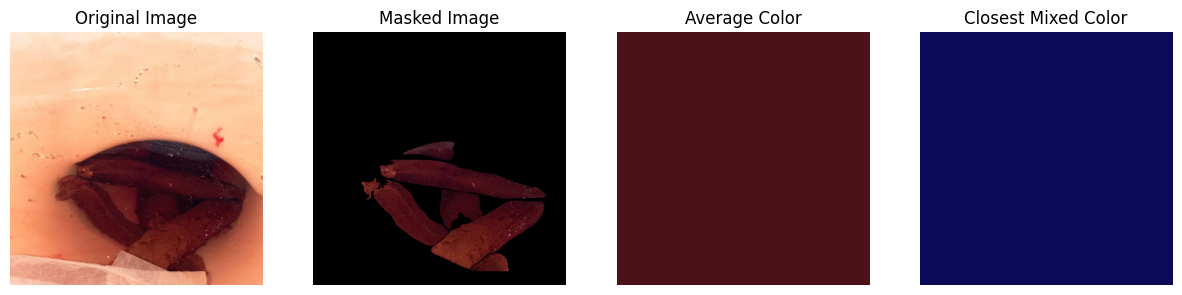

Is hemorrhage present? True


In [3]:
# image_path = "/root/ai/dataset/classification/test/1/163_jpeg_jpg.rf.7ec4e8e62f5208c234a37d126efa02bb.jpg"
# mask_path = "/root/ai/dataset/classification/test/1/163_jpeg_jpg.rf.7ec4e8e62f5208c234a37d126efa02bb_mask.png"

# image_path = "/root/ai/dataset/mask_1513_split/img/33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25.jpg"
# mask_path = "/root/ai/dataset/mask_1513_split/mask/33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25_mask.png"
image_path = "/root/ai/dataset/classification/train/4/Type3_iter348_jpg.rf.0996ba2bab045b26264af1a3418c7f19.jpg"
mask_path = "/root/ai/dataset/classification/train/4/Type3_iter348_jpg.rf.0996ba2bab045b26264af1a3418c7f19_mask.png"

threshold = 50

mean_val_bgr, masked_image = calculate_average_color(image_path, mask_path)
hemorrhage_present, closest_mixed_color = is_hemorrhage_present(mean_val_bgr, masked_image, threshold)

# 시각화
plt.figure(figsize=(15, 5))

# 원본 이미지
original_image = Image.open(image_path)
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# 마스크 적용 이미지
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image")
plt.axis('off')

# 평균 색상 시각화
plt.subplot(1, 4, 3)
avg_color_image = np.zeros((100, 100, 3), dtype=np.uint8)
avg_color_image[:] = [int(mean_val_bgr[0]), int(mean_val_bgr[1]), int(mean_val_bgr[2])]
plt.imshow(cv2.cvtColor(avg_color_image, cv2.COLOR_BGR2RGB))
plt.title("Average Color")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.full((100, 100, 3), closest_mixed_color, dtype=np.uint8))
plt.title(f"Closest Mixed Color")
plt.axis("off")

plt.show()
print("Is hemorrhage present?", hemorrhage_present)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def calculate_average_color(masked_image):
    non_white_mask = np.all(masked_image != [255, 255, 255], axis=-1)
    # 흰색이 아닌 픽셀들만 평균 색상 계산
    selected_pixels = masked_image[non_white_mask]
    mean_val_rgb = np.mean(selected_pixels, axis=0)
    # RGB -> BGR 순서로 변경
    mean_val_bgr = mean_val_rgb[::-1]
    return mean_val_bgr, masked_image

def calculate_mixture_color(mean_val_bgr, red_color, alpha=0.5):
    mixed_color = (alpha * mean_val_bgr + (1 - alpha) * red_color).astype(int)
    return mixed_color

def is_hemorrhage_present(mean_val_bgr, masked_image, thresholds, pixel_threshold=10, alpha=0.5):
    red_colors = [
        np.array([0, 0, 102]),  # #660000
        np.array([0, 0, 139]),  # #8B0000
        np.array([0, 0, 128]),  # #800000
        np.array([0, 17, 204]), # #CC1100
        np.array([60, 20, 220]) # #DC143C
    ]
    
    min_distance = float('inf')
    closest_mixed_color = None
    
    # 전체 평균 색상에 대한 검사
    for red_color in red_colors:
        mixed_color = calculate_mixture_color(mean_val_bgr, red_color, alpha)
        distance = np.linalg.norm(mean_val_bgr - mixed_color)
        if distance < min_distance:
            min_distance = distance
            closest_mixed_color = mixed_color
            
    # 특정 임계값 이하의 색상이 있으면 True 반환
    if min_distance < thresholds:
        return True, closest_mixed_color
    
    # 픽셀 단위 검사 (국소적 혈변 감지)
    red_count = 0
    for y in range(masked_image.shape[0]):
        for x in range(masked_image.shape[1]):
            pixel = masked_image[y, x, :]
            if not np.all(pixel == [255, 255, 255]):  # 배경이 아닌 픽셀만 고려
                for red_color in red_colors:
                    distance = np.linalg.norm(pixel - red_color)
                    if distance < thresholds:
                        red_count += 1
                        if red_count >= pixel_threshold:
                            return True, closest_mixed_color
    
    return False, closest_mixed_color


Is hemorrhage present? True
[15.76314776 46.0449787  69.03118209]


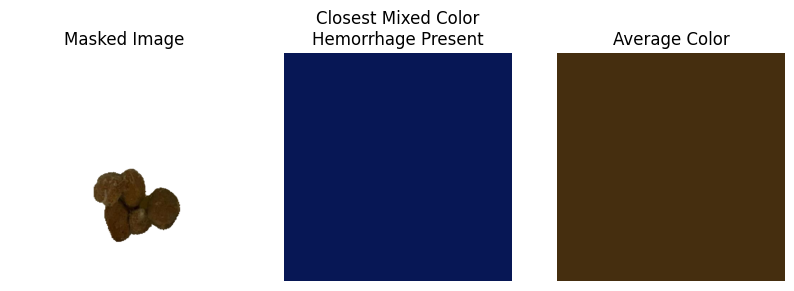

In [3]:

# 이미지 로드 및 처리
masked_img_path = "/root/ai/predict/33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25_masked.png"
masked_image = cv2.imread(masked_img_path)
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환

# 평균 색상 계산
mean_val_bgr, _ = calculate_average_color(masked_image)

# 혈변 여부 판단
thresholds = 100  # 특정 거리 임계값 (이 값을 조정할 수 있음)
is_blood, closest_mixed_color = is_hemorrhage_present(mean_val_bgr, masked_image, thresholds)
print("Is hemorrhage present?", is_blood)
# 결과 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.imshow(masked_image)
plt.title("Masked Image")
plt.axis("off")

# 혈변 여부 결과
result_text = "Hemorrhage Present" if is_blood else "No Hemorrhage Detected"
plt.subplot(1, 3, 2)
plt.imshow(np.full((100, 100, 3), closest_mixed_color, dtype=np.uint8))
plt.title(f"Closest Mixed Color\n{result_text}")
plt.axis("off")

# 평균 색상 시각화
plt.subplot(1, 3, 3)
avg_color_image = np.zeros((100, 100, 3), dtype=np.uint8)
print(mean_val_bgr)
avg_color_image[:] = [int(mean_val_bgr[0]), int(mean_val_bgr[1]), int(mean_val_bgr[2])]
plt.imshow(cv2.cvtColor(avg_color_image, cv2.COLOR_BGR2RGB))
plt.title("Average Color")
plt.axis('off')
plt.show()